# metabolite2vec:
In this notebook, the word2vec algorithm and skipgram model for embedding words in a feature space that represents their context (https://arxiv.org/pdf/1310.4546.pdf) was adapted to embed metabolites. The code here was initially adapted from the TensorFlow word2vec tutorial (https://www.tensorflow.org/tutorials/representation/word2vec).

### Step 1: Load the Data
The data used for this project is a large database of metabolites and metabolic reactions from ModelSEED. This databases consists of 27,694 metabolites and 34,711 reactions, which can be downloaded from the ModelSEED github. Metabolite and reaction details can be viewed on the model seed website (modelseed.org).

In [5]:
# Load Data (ModelSEED database reactions, modelseed.org)
# The modelseed reactions metadata has a column corresponding to the metabolites used by a reaciton, 
# this column will be the entirety of our data.

import csv
file_name = './reactions.tsv'
data_c = []
with open(file_name) as tsvfile:
    reader = csv.DictReader(tsvfile,dialect='excel-tab')
    for row in reader:
        tmp = row['compound_ids']
        data_c.append(tmp.split(';'))


In [6]:
# Load metabolite names
# Metabolites names will be used for a dictionary that converts metabolite ids to names for data visualization
file_name = './compounds.tsv'
name_dictionary = dict()
with open(file_name) as tsvfile:
    reader = csv.DictReader(tsvfile,dialect='excel-tab')
    for row in reader:
        tmp1 = row['id']
        tmp2 = row['abbreviation']
        name_dictionary[tmp1]=tmp2

In [7]:
# Deifne other dictionarys for data manipulation
# count, dictionary, reverse_dictionary, data, sort_dicitonary

# count: the number of times each metabolite appears in any reaction
from collections import Counter
from itertools import chain
count = Counter(chain.from_iterable(data_c))

# dictionary: to convert metabolite ids to a unique index
dictionary = dict()
for word in count:
    dictionary[word] = len(dictionary)
# reverse_dicitonary: to convert metabolite index back to ids
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

# data: convert metabolite id data to index data
data = []
for rxn in data_c:
    data.append([dictionary[cmp] for cmp in rxn])

# vocabulary size: the total number of unique metabolites
vocabulary_size = len(count)

# sort dictionary: dictionary to get metabolite index sorted by count
import operator
sorted_count = sorted(count.items(), key=operator.itemgetter(1))
sorted_count.reverse()
sort_dictionary = dict()
for x in sorted_count:
    tmp = x[0]
    sort_dictionary[len(sort_dictionary)] = dictionary[tmp]

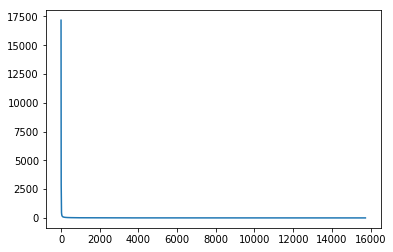

In [9]:
# Plot data
# plot the frequency of metabolite counts in reactions to get an idea of what the data looks like
import matplotlib.pyplot as plt
import numpy as np

sorted_count_a = np.array(sorted_count)
plt.plot(sorted_count_a[:,1].astype(float))
plt.show()

### Step 2: Define how to Sample the Data
The data is sampled by defining metabolites as words and metabolites that are products or reactants of the same reaction as context metabolites. To generate a single sample for a minibatch first a reaction is chosen at random, then 1 center and 1 context metabolite from that reaction are chosen at random as the input and label of the sampled data point. The model thus adjusts metabolite embeddings such that metabolites dot products predict metabolites that appear in the same context in metabolic reactions.

In [10]:
# Define function for generating a training batch
# Context is defined as all of the metabolites in a given reaction
# A batch is sampled by first randomly choosing a reaction and then randomly choosing 1 center and 1 neighbor metabolite
from random import randint
import numpy as np

def generate_batch(batch_size):
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        #choose random reaction
        tmp = data[randint(0,vocabulary_size-1)]
        #choose random metabolite
        batch[i] = tmp[randint(0,len(tmp)-1)]
        labels[i] = tmp[randint(0,len(tmp)-1)]
    
    return batch, labels

batch, labels = generate_batch(10)


In [11]:
# visualize a batch
batch_size = 10
batch, labels = generate_batch(batch_size)
for i in range(batch_size):
  print(batch[i], name_dictionary[reverse_dictionary[batch[i]]], '->', labels[i, 0],
        name_dictionary[reverse_dictionary[labels[i, 0]]])

115 atp -> 1484 Ethylamine
0 h2o -> 178 ade
123 akg -> 273 succ
8885 GUANOSINE_DIPHOSPHATE_FUCOSE -> 3 h
205 ac -> 205 ac
115 atp -> 4145 fa1
14 gtp -> 287 ahdt
135 nadp -> 135 nadp
4 co2 -> 4 co2
3 h -> 3 h


### Step 3: Skip-gram Model
A skip-gram model with noise contrastive estimation (NCE) loss was used for our method. For a quick introduction to the skip-gram model and how it translates over to a neural network see (http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

In [12]:
# Build and train a skip-gram model.

import tensorflow as tf
import math

# Hyperparameters:
batch_size = 128 # Size of mini-batch
embedding_size = 128  # Dimension of the embedding vector.
num_sampled = 64  # Number of negative examples to sample.
lr = 1 # Learning rate for Stochastic Gradient Descent

# Validation set: A set of metabolites to monitor the progress of the algorithm
# The metabolites chosen here do not impact the calculations
valid_size = 10  # number of validation examples to show
valid_examples_1 = range(valid_size)
valid_examples = [sort_dictionary[ex] for ex in valid_examples_1] #chooes the metabolites with the highest counts

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)
    
  # Construct the SGD optimizer
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    
  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()


In [13]:
# Begin training.

num_steps = 100001

with tf.Session(graph=graph) as session:

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val
    

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 3  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % name_dictionary[valid_word]
        for k in range(top_k):
          close_word = name_dictionary[reverse_dictionary[nearest[k]]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  258.0563049316406
Nearest to h: Complement-5-alpha-prime, cytcc, 4-Fluorocatechol,
Nearest to h2o: Geniposidic acid, formh4spt, 3kc26coa,
Nearest to nadp: 6-26-BISN-ACETYL-ETCETERA-MANNOSYL-R, N-acetylmuramoyl-L-ala-D-glu, Xyloglucans-Galactose-23,
Nearest to nadph: 3-Oxo-5,6-dehydrosuberyl-CoA, Protein-L-methionine-R-S-oxides, 2-Hydroxy-vitamin K,
Nearest to o2: trnaser, zeta-Carotene, 7,8-Duhydro-D-neopterin,
Nearest to atp: pectin, N-Acyl-D-mannosaminolactone, (-)-Citronellol,
Nearest to pi: 6-Thioinosine-5'-diphosphate, BCAA-dehydrogenase-DH-lipoyl, 1,4-beta-D-Mannan,
Nearest to nad: cyanidin 3-(p-coumaroyl)-glucoside, 2'-Hydroxy caffeic acid, Glc-EGF-like-domain,
Nearest to nadh: Pratensein, Hyp(4-b1)Ara(2-b1)Ara, hkntd,
Nearest to adp: Aminated-Amine-Donors, 3-Isochromanone, Plumbagin,
Average loss at step  2000 :  57.29204818630218
Average loss at step  4000 :  10.931588152170182
Average loss at step  6000 :  5.109408626675606
Average loss 

### Step 4: Visualize Data

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 1000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [name_dictionary[reverse_dictionary[i]] for i in range(plot_only)]

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

x = low_dim_embs[:,0]
y = low_dim_embs[:,1]

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))

scatter = ax.scatter(x,
                     y)
ax.grid(color='white', linestyle='solid')

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [16]:
# Explore Word Similarity
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

cos_sim = 1-pairwise_distances(final_embeddings, metric="cosine")

In [20]:
# What are the closest metabolites
topN = 50
cos_sim_1 = cos_sim - np.triu(cos_sim) # subtract upper triangel and diagonal
cos_sim_1d = cos_sim_1.flatten()
idx_1d = cos_sim_1d.argsort()[-topN:]
x_idx, y_idx = np.unravel_index(idx_1d, cos_sim.shape)


In [23]:
# cosine similarity vs number of times reactions co-occur
# count co-occurences
met_co = np.zeros_like(cos_sim)
for inds in data:
    for x in inds:
        for y in inds:
            met_co[x,y]=met_co[x,y]+1


In [27]:
# correlation of top n
from scipy.stats import spearmanr
rho, pval = spearmanr(met_co[x_idx,y_idx],cos_sim[x_idx,y_idx])
print(rho)
print(pval)

0.5490267795549585
3.649439753900711e-05


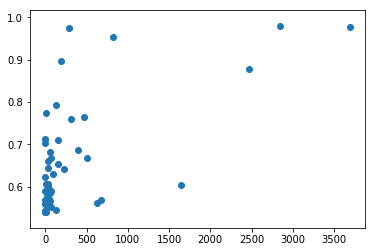

In [29]:
plt.scatter(met_co[x_idx,y_idx],cos_sim[x_idx,y_idx])
plt.show()

In [37]:
# normalized co-occurence counts (only calculate for top n to save time)
met_co_norm = np.zeros_like(met_co)
for x,y in zip(x_idx, y_idx):
    met_co_norm[x,y] = 2*met_co[x,y]/(met_co[x,x]+met_co[y,y])

In [38]:
rho, pval = spearmanr(met_co_norm[x_idx,y_idx],cos_sim[x_idx,y_idx])
print(rho)
print(pval)

0.4819084658940992
0.0003948200118919194


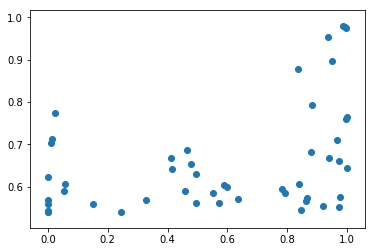

In [39]:
plt.scatter(met_co_norm[x_idx,y_idx],cos_sim[x_idx,y_idx])
plt.show()

In [46]:
for x,y in zip(x_idx, y_idx):
    print(name_dictionary[reverse_dictionary[x]])
    print([reverse_dictionary[x]])
    print(name_dictionary[reverse_dictionary[y]])
    print([reverse_dictionary[y]])
    print("Cosine Similarity: {}".format(cos_sim[x][y]))
    print("Metabolite Co-occurrence: {}".format(met_co[x][y]))
    print("Normalized Co-occurence: {}".format(met_co_norm[x][y]))
    print('')

17-Hydroxylupanine
['cpd21466']
sheme
['cpd00557']
Cosine Similarity: 0.5405967235565186
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

ptd4ino_SC
['cpd15288']
adocbl
['cpd00166']
Cosine Similarity: 0.5417420864105225
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

thidit
['cpd16831']
trdox
['cpd11420']
Cosine Similarity: 0.5419166088104248
Metabolite Co-occurrence: 10.0
Normalized Co-occurence: 0.24390244483947754

fa13
['cpd17008']
Anteisobranched cardiolipin
['cpd16672']
Cosine Similarity: 0.5428910851478577
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

Rhodopinal glucoside
['cpd14987']
Amidines
['cpd03611']
Cosine Similarity: 0.543175458908081
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

q8h2
['cpd15561']
q8
['cpd15560']
Cosine Similarity: 0.5466176271438599
Metabolite Co-occurrence: 124.0
Normalized Co-occurence: 0.8464163541793823

Reduced-ferredoxins
['cpd28082']
Oxidized-ferredoxins
['cpd27757']
Cosine Similarity: 0.55343043

In [44]:
# Find closest metabolites to a particular metabolite
met = 'cpd00005'
topN = 10
cos_sim_met = cos_sim[dictionary[met]][:]
ids = cos_sim_met.argsort()[-topN:]

for x in ids:
    print(name_dictionary[reverse_dictionary[x]])
    print("Cosine Similarity: {}".format(cos_sim[x][dictionary[met]]))
    print("Metabolite Co-occurrence: {}".format(met_co[x][dictionary[met]]))
    print('')

2'-Hydroxyisoflavone
Cosine Similarity: 0.4500058889389038
Metabolite Co-occurrence: 1.0

Phenylboronic acid
Cosine Similarity: 0.45009756088256836
Metabolite Co-occurrence: 0.0

nad
Cosine Similarity: 0.45850276947021484
Metabolite Co-occurrence: 25.0

DHI
Cosine Similarity: 0.4613311290740967
Metabolite Co-occurrence: 0.0

nadh
Cosine Similarity: 0.4633355140686035
Metabolite Co-occurrence: 30.0

Ferricytochrome c2
Cosine Similarity: 0.46350371837615967
Metabolite Co-occurrence: 1.0

alpha-Santonin
Cosine Similarity: 0.468707799911499
Metabolite Co-occurrence: 1.0

Oxo-glutarate-dehydro-suc-DH-lipoyl
Cosine Similarity: 0.4734034538269043
Metabolite Co-occurrence: 0.0

nadp
Cosine Similarity: 0.9776964783668518
Metabolite Co-occurrence: 3690.0

nadph
Cosine Similarity: 1.0
Metabolite Co-occurrence: 3708.0



### Comments
In this notebook we have implemented the skip-gram model from word2vec towards embedding metabolites by using metabolic reactions as the context. Metabolites that co-occur often with other metabolites such as the cofactors nadph and nadp or atp and adp have very high similarity in this embedding space. These metabolites can be thought of as "phrases" that co-occur often and thus are always found in similar context. Additionally, there are some metabolites that have high similarity in the embedding space, but low co-occurence. One example is, alpha-D-glucose, glc-D-B and glc-D. In the modelSEED database these metabolites are alpha-D-Glucose, beta-D-Glucose and D-Glucose, respectively. These metabolites have similar structure and participate in similar reacitons. For example, in the modelSEED database rxn00007 hydrolyzes Trehalose to 2 D-Glucose, while rxn15002 hydrolyzes Trehalose to 2 alpha-D-Glucose.

#### Future Directions:
* Embed metabolite "phrases" by reassigning highly co-occurring metabolites to a unique "phrase" IDs
* Utilize more sophisticated reaction structures such as KEGG reaction classes to embed different components of reactions